# 1. Importing necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE, RandomOverSampler

# 2. Reading the Data sets

In [2]:
train=pd.read_csv("Loan_Status_train.csv")
test=pd.read_csv("Loan_Status_test.csv")
print("Train data", train.shape)
print("Test data", test.shape)

Train data (614, 13)
Test data (367, 12)


In [3]:
test2=test.copy()

👉 There are 614 observations in the train data set and 367 observations in the test data set.

# 3. EDA 🔍

In [4]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


👉 As can be seen, the 13 columns are readable. 

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


👉 There are **13 variables** in this data set:
*   **8 categorical** variables,
*   **3 continuous** variables,
*    **1 discrete numerical** variable,and
*   **1** variable to accommodate the loan ID.

In [6]:
num_cols=train.select_dtypes(include='number').columns.tolist()
cat_cols=train.select_dtypes(include='object').columns.tolist()
print(num_cols)
print(cat_cols)                             

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


In [7]:
num_cols.remove('Credit_History')
num_cols.remove('Loan_Amount_Term')
num_dis_cols=[]
num_dis_cols.append('Credit_History')
num_dis_cols.append('Loan_Amount_Term')
cat_cols.remove('Loan_Status')
cat_cols.remove('Loan_ID')
print(num_cols)
print(cat_cols)
print(num_dis_cols)

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
['Credit_History', 'Loan_Amount_Term']


## 3.1 Exploring categorical columns

In [8]:
for col in cat_cols:
    print(col, ":", train[col].unique())

Gender : ['Male' 'Female' nan]
Married : ['No' 'Yes' nan]
Dependents : ['0' '1' '2' '3+' nan]
Education : ['Graduate' 'Not Graduate']
Self_Employed : ['No' 'Yes' nan]
Property_Area : ['Urban' 'Rural' 'Semiurban']


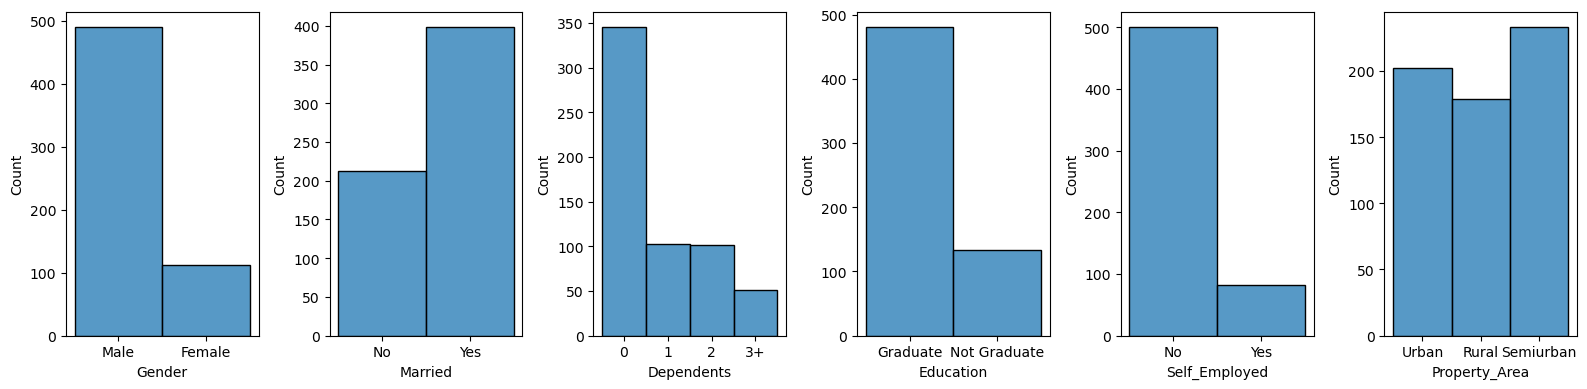

In [9]:
fig, axes = plt.subplots(1, len(cat_cols), figsize=(16, 4))

for i, col in enumerate(cat_cols):
    sns.histplot(train[col], ax=axes[i]) 

plt.tight_layout()
plt.show()

👉 The data shows that more applicants are **male, married, have zero dependents, are graduates, not self-employed, live in semiurban areas**, and have approved loans compared to their counterparts.

👉 All object type columns here are categorical and nominal

#### 3.1.1 Loan_ID

In [10]:
train.Loan_ID.nunique()

614

👉 It can be seen that there are 614 unique IDs in the dataset

#### 3.1.2 Gender

In [11]:
train.Gender.value_counts(dropna=False)

Male      489
Female    112
NaN        13
Name: Gender, dtype: int64

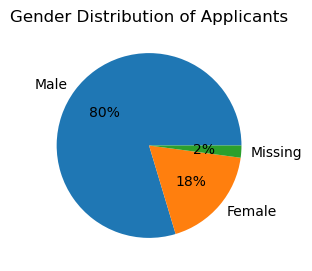

In [12]:
countmale=len(train[train.Gender=='Male'])
countfemale=len(train[train.Gender=='Female'])
countnull=len(train[train.Gender.isnull()])
total=len(train.Gender)
percent_male = (countmale / total) * 100
percent_female = (countfemale / total) * 100
percent_null = (countnull / total) * 100
labels = ['Male', 'Female', 'Missing']
sizes = [percent_male, percent_female, percent_null]
plt.figure(figsize=(3,3))
plt.title('Gender Distribution of Applicants')
plt.pie(sizes, labels=labels, autopct='%.0f%%')
plt.show()

👉 From the above results, it can be observed that the number of male applicants is higher compared to female applicants.

#### 3.1.3 Married 

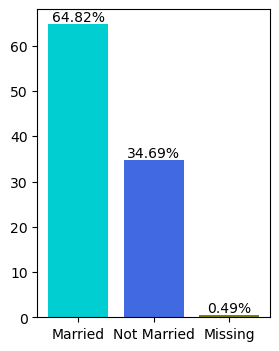

In [13]:
countmarried=len(train[train.Married=='Yes'])
countunmarried=len(train[train.Married=='No'])
countnull=len(train[train.Married.isnull()])
total=len(train.Married)
percent_married = (countmarried/ total) * 100
percent_not_married = (countunmarried / total) * 100
percent_null = (countnull / total) * 100
labels = ['Married', 'Not Married', 'Missing']
plt.figure(figsize=(3,4))
percentages = [percent_married, percent_not_married, percent_null]
bars=plt.bar(labels, percentages, color=['darkturquoise', 'royalblue', 'olive'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')
plt.show()

👉 The number of applicants that has been married is higher compared to applicants that hasn't married. It also can be seen there are small number of missing values in this column.

#### 3.1.4 Education

In [14]:
train.Education.value_counts(dropna=False)

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

👉 The number of applicants that has been graduated is higher compared to applicants that hasn't graduated.

#### 3.1.5 Self_Employed

In [15]:
train.Self_Employed.value_counts(dropna=False)

No     500
Yes     82
NaN     32
Name: Self_Employed, dtype: int64

👉 The number of applicants that are not self employed is higher compared to applicants that are self employed. It also can be seen, there are missing values in this column.

#### 3.1.6 Property_Area

In [16]:
train['Property_Area'].value_counts(dropna=False)

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

 👉 This column has a balanced distribution between Urban, Rural, and Semiurban property area. It also can be seen there is no missing value.

#### 3.1.7 Loan_Status (Target Variable)

In [17]:
train['Loan_Status'].unique()

array(['Y', 'N'], dtype=object)

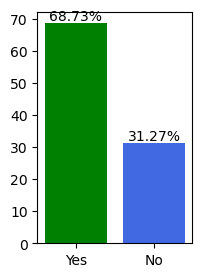

In [18]:
count_yes=len(train[train.Loan_Status=='Y'])
count_no=len(train[train.Loan_Status=='N'])
n=len(train.Loan_Status)
yes_per=(count_yes/n)*100
no_per=(count_no/n)*100
labels=['Yes', 'No']
percentages=[yes_per, no_per]
plt.figure(figsize=(2,3))
bars=plt.bar(labels, percentages, color=['green', 'royalblue'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')
plt.show()


👉 The number of approved loans is higher compared to rejected loans.

In [19]:
for col in cat_cols:
    print(col, ":", train[col].mode()[0])

Gender : Male
Married : Yes
Dependents : 0
Education : Graduate
Self_Employed : No
Property_Area : Semiurban


## 3.2 Discrete Numerical columns Data Exploration

#### 3.2.1 Credit_History

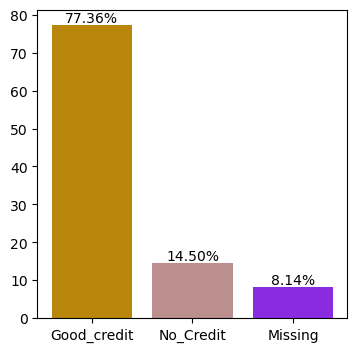

In [20]:
good_credit_his=len(train[train.Credit_History==1])
no_credit_his=len(train[train.Credit_History==0])
countnull=len(train[train.Credit_History.isnull()])
total=len(train.Credit_History)
percent_credit_his = (good_credit_his / total) * 100
percent_no_credit = (no_credit_his / total) * 100
percent_null = (countnull / total) * 100
labels = ['Good_credit', 'No_Credit', 'Missing']
plt.figure(figsize=(4,4))
percentages = [percent_credit_his, percent_no_credit, percent_null]
bars=plt.bar(labels, percentages, color=['darkgoldenrod','rosybrown', 'blueviolet'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')
plt.show()

👉 The number of applicants that have good credit history is higher compared to applicants that have bad credit history. It also can be seen, there are missing values in this column.

#### 3.2.2 Loan_Amount_Term

In [21]:
print(train['Loan_Amount_Term'].unique())
print((train['Loan_Amount_Term']//12).unique())

[360. 120. 240.  nan 180.  60. 300. 480.  36.  84.  12.]
[30. 10. 20. nan 15.  5. 25. 40.  3.  7.  1.]


👉The above array for Loan_Amount_Term indicates that it is discrete data, not continuous.

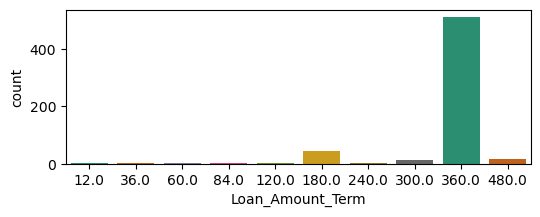

In [22]:
plt.figure(figsize=(6,2))
sns.countplot(x='Loan_Amount_Term', data=train, palette='Dark2')
plt.show()

## 3.3 Continuous Numerical columns Data Exploration 


In [23]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


In [24]:
for col in num_cols:
    print(col, ":", train[col].mode()[0])

ApplicantIncome : 2500
CoapplicantIncome : 0.0
LoanAmount : 120.0


#### 3.3.1 Loan_Amount

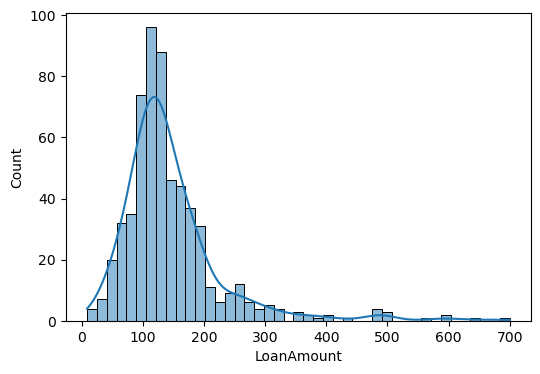

In [25]:
plt.figure(figsize=(6,4))
sns.histplot(x='LoanAmount', data=train, kde=True)
plt.show()

👉The above Histogram for LoanAmount is positively skewed. It implies that the distribution of LoanAmount values is skewed towards higher values. A tail towards the right side (higher values) of the distribution indicates some outliers or higher values.

#### 3.3.2 ApplicantIncome

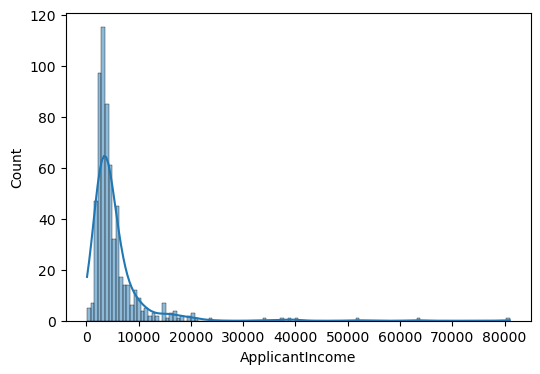

In [26]:
plt.figure(figsize=(6,4))
sns.histplot(x='ApplicantIncome', data=train, kde=True)
plt.show()

👉The above Histogram for ApplicantIncome is positively skewed. It implies that the distribution of LoanAmount values is skewed towards higher values. A tail towards the right side (higher values) of the distribution indicates some outliers or higher values.

#### 3.3.3 CoapplicantIncome

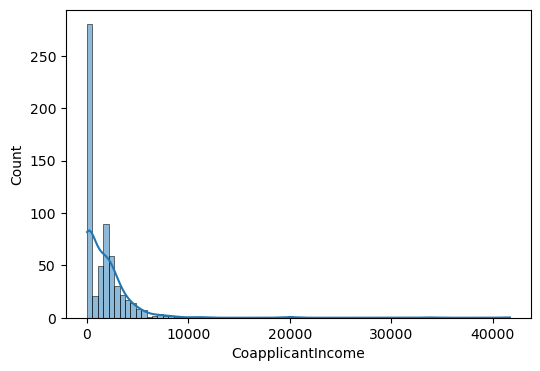

In [27]:
plt.figure(figsize=(6,4))
sns.histplot(x='CoapplicantIncome', data=train, kde=True)
plt.show()

👉The above Histogram for CoapplicantIncome is positively skewed. It implies that the distribution of LoanAmount values is skewed towards higher values. A tail towards the right side (higher values) of the distribution indicates some outliers or higher values.

# 4. Other Exploration 💹

## 4.1 Violin Plot 🎻

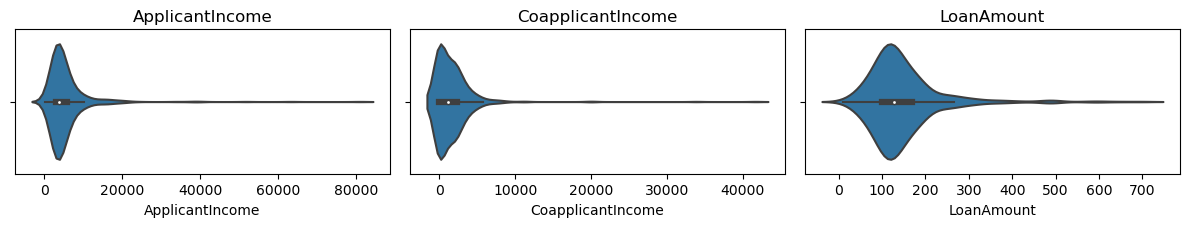

In [28]:
plt.figure(figsize=(12,6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(x=train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

## 4.2 Box Plot 

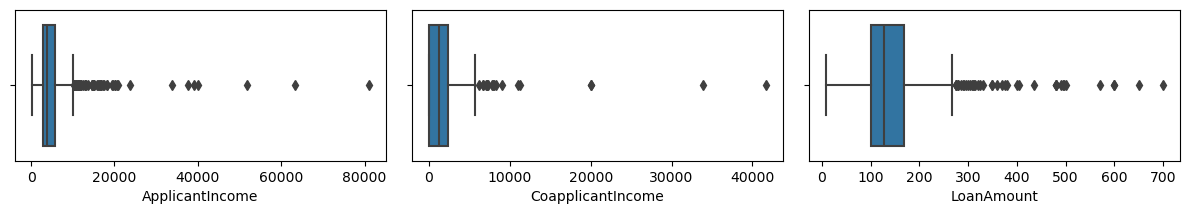

In [29]:
plt.figure(figsize=(12,6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train[col])
plt.tight_layout()
plt.show()

In [30]:
corr_matrix=train.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
ApplicantIncome,1.000000,-0.116605,0.570909,-0.045306,-0.014715
CoapplicantIncome,-0.116605,1.000000,0.188619,-0.059878,-0.002056
LoanAmount,0.570909,0.188619,1.000000,0.039447,-0.008433
Loan_Amount_Term,-0.045306,-0.059878,0.039447,1.000000,0.001470
Credit_History,-0.014715,-0.002056,-0.008433,0.001470,1.000000


👉 There is a moderate positive correlation (0.5709), indicating that higher applicant incomes are associated with higher loan amounts. Credit_History has very weak correlations with all other variables in this matrix, implying it might be largely independent of these other factors.

In [31]:
train['Credit_History'].unique()

array([ 1.,  0., nan])

In [32]:
num_cols_list=num_cols.copy()
train1=train.copy()
train1['Loan_Status'] = train1['Loan_Status'].map({'Y': 1, 'N': 0})

for col in num_cols_list:
    missing_value= train1[col].isnull()
    corr_with_target=train1[-missing_value].corr()['Loan_Status'][col]
    print("Point-biserial correlation with ",col, ":" , corr_with_target)

Point-biserial correlation with  ApplicantIncome : -0.0047095226593515584
Point-biserial correlation with  CoapplicantIncome : -0.059187313487850064
Point-biserial correlation with  LoanAmount : -0.037317768699794175


In [33]:
for col in num_dis_cols:
    missing_value= train1[col].isnull()
    corr_with_target=train1[-missing_value].corr()['Loan_Status'][col]
    print("Point-biserial correlation with ",col, ":" , corr_with_target)    

Point-biserial correlation with  Credit_History : 0.5616781574653794
Point-biserial correlation with  Loan_Amount_Term : -0.021267658123862963


## 4.3 Categorical vs Categorical

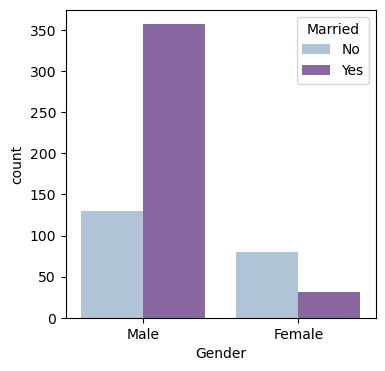

In [34]:
plt.figure(figsize=(4,4))
sns.countplot(x='Gender', data=train, hue='Married', palette='BuPu')
plt.show()

👉 Most male applicants are already married compared to female applicants. Also, the number of not married male applicants are higher compare to female applicants that had not married.

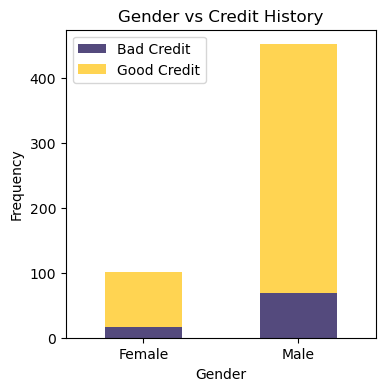

In [35]:
pd.crosstab(train.Gender, train.Credit_History).plot(kind="bar", stacked=True, figsize=(4,4), color=['#544a7d','#ffd452'])
plt.title('Gender vs Credit History')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.legend(["Bad Credit", "Good Credit"])
plt.xticks(rotation=0)
plt.show()

👉 Among applicants both Male and Female have good credit history implies that credit history is not significantly influenced by gender

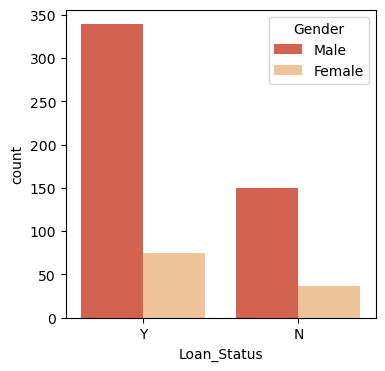

In [36]:
plt.figure(figsize=(4,4))
sns.countplot(x='Loan_Status', data=train, hue='Gender', palette='OrRd_r')
plt.show()

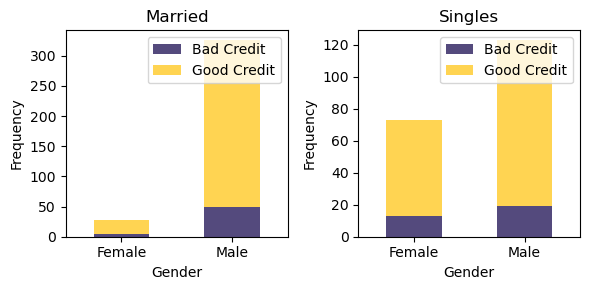

In [37]:
female_married_data = train[(train['Gender'] == 'Female') & (train['Married'] == 'Yes')]
female_single_data = train[(train['Gender'] == 'Female') & (train['Married'] == 'No')]
male_married_data = train[(train['Gender'] == 'Male') & (train['Married'] == 'Yes')]
male_single_data = train[(train['Gender'] == 'Male') & (train['Married'] == 'No')]
married_ct = pd.crosstab([female_married_data['Gender']], female_married_data['Credit_History']).add(pd.crosstab([male_married_data['Gender']], male_married_data['Credit_History']), fill_value=0)
single_ct = pd.crosstab([female_single_data['Gender']], female_single_data['Credit_History']).add(pd.crosstab([male_single_data['Gender']], male_single_data['Credit_History']), fill_value=0)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
married_ct.plot(kind="bar", stacked=True, color=['#544a7d', '#ffd452'], ax=axes[0])
axes[0].set_title('Married')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Frequency')
axes[0].legend(["Bad Credit", "Good Credit"], loc='upper right')
axes[0].tick_params(axis='x', rotation=0)
single_ct.plot(kind="bar", stacked=True, color=['#544a7d', '#ffd452'], ax=axes[1])
axes[1].set_title('Singles')
axes[1].set_ylabel('Frequency')
axes[1].legend(["Bad Credit", "Good Credit"], loc='upper right')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [38]:
print("Married:")
print(married_ct)
print("\nSingle:")
print(single_ct)

Married:
Credit_History   0.0    1.0
Gender                     
Female           4.0   23.0
Male            50.0  276.0

Single:
Credit_History   0.0    1.0
Gender                     
Female          13.0   60.0
Male            19.0  104.0


👉 Among (Married and Unmarried) applicants both Male and Female have good credit history implies that credit history is not significantly influenced by Married Status

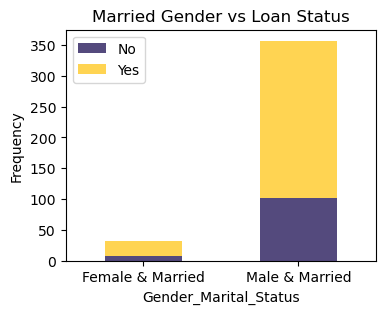

In [39]:
married_applicants = train[train['Married'] == 'Yes'].copy()
married_applicants.loc[:, 'Gender_Marital_Status'] = married_applicants['Gender'] + ' & Married'
crosstab = pd.crosstab(married_applicants['Gender_Marital_Status'], married_applicants['Loan_Status'])
crosstab.plot(kind="bar", stacked=True, figsize=(4, 3), color=['#544a7d', '#ffd452'])
plt.title('Married Gender vs Loan Status')
plt.ylabel('Frequency')
plt.legend(["No", "Yes"])
plt.xticks(rotation=0)
plt.show()

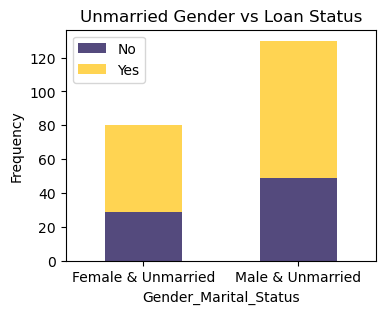

In [40]:
unmarried_applicants = train[train['Married'] == 'No'].copy()
unmarried_applicants.loc[:, 'Gender_Marital_Status'] = unmarried_applicants['Gender'] + ' & Unmarried'
crosstab = pd.crosstab(unmarried_applicants['Gender_Marital_Status'], unmarried_applicants['Loan_Status'])
crosstab.plot(kind="bar", stacked=True, figsize=(4, 3), color=['#544a7d', '#ffd452'])
plt.title('Unmarried Gender vs Loan Status')
plt.ylabel('Frequency')
plt.legend(["No", "Yes"])
plt.xticks(rotation=0)
plt.show()

In [41]:
married_applicants = train[train['Married'] == 'Yes']
unmarried_applicants = train[train['Married'] == 'No']

# Calculate counts for married applicants by gender and loan status
married_counts = married_applicants.groupby(['Gender', 'Loan_Status']).size().reset_index(name='Count')

# Calculate counts for unmarried applicants by gender and loan status
unmarried_counts = unmarried_applicants.groupby(['Gender', 'Loan_Status']).size().reset_index(name='Count')

# Display the counts
print("Married Applicants:")
print(married_counts)
print("\nUnmarried Applicants:")
print(unmarried_counts)

Married Applicants:
   Gender Loan_Status  Count
0  Female           N      8
1  Female           Y     23
2    Male           N    101
3    Male           Y    256

Unmarried Applicants:
   Gender Loan_Status  Count
0  Female           N     29
1  Female           Y     51
2    Male           N     49
3    Male           Y     81


* For both genders, married applicants generally have a higher approval rate compared to unmarried applicants.
* Among both married and unmarried applicants, males have a higher number of loan approvals (Y) compared to females.

In [42]:
cross_tab=pd.crosstab(train.Self_Employed,train.Loan_Status)
percentages = cross_tab.apply(lambda row: round(row / row.sum() * 100, 2), axis=1)
print("Self Employed vs Loan Status:")
print(percentages)

Self Employed vs Loan Status:
Loan_Status        N      Y
Self_Employed              
No             31.40  68.60
Yes            31.71  68.29


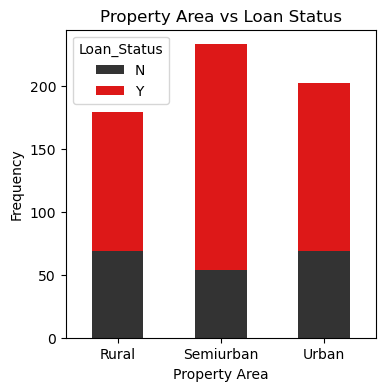

In [43]:
pd.crosstab(train.Property_Area,train.Loan_Status).plot(kind="bar", stacked=True, figsize=(4,4), color=['#333333','#dd1818'])
plt.title('Property Area vs Loan Status')
plt.xlabel('Property Area')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

👉 Most of loan that got accepted has property in Semiurban compared to Urban and Rural.

## 4.4 Categorical vs Numerical

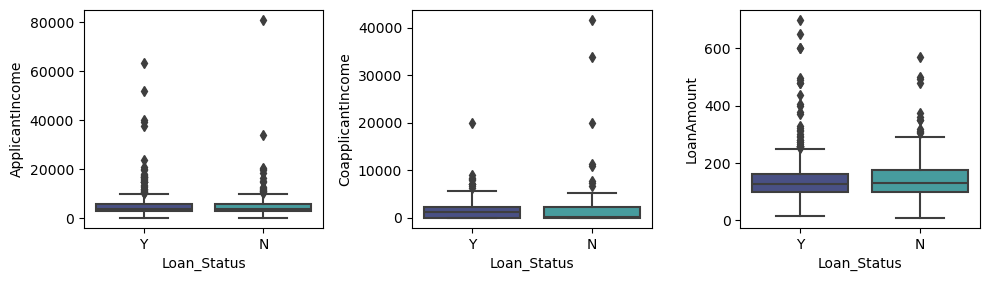

In [44]:
plt.figure(figsize=(10,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x="Loan_Status", y=col, data=train, palette="mako")
plt.tight_layout()
plt.show()

## 4.5 Null Values

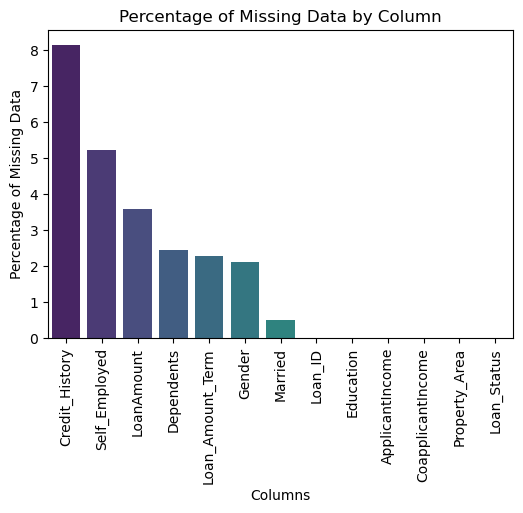

In [45]:
missing_values =((train.isnull().sum())/ len(train)) * 100
msg_percent = missing_values.sort_values(ascending=False)
plt.figure(figsize=(6,4), edgecolor='black')
sns.barplot(x=msg_percent.index, y=msg_percent.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Data')
plt.title('Percentage of Missing Data by Column')
plt.show()

In [46]:
total_null=train.isnull().sum().sort_values(ascending=False)
total_null

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

# 5. Data Preprocessing

## 5.1 Feature Engineering

#### 5.1.1 Creating Interaction Features

In [47]:
train['Total_Income']=train['ApplicantIncome']+train['CoapplicantIncome']
test['Total_Income']=test['ApplicantIncome']+test['CoapplicantIncome']
train.Loan_Status=train.Loan_Status.map({'Y':1 , 'N':0})

In [48]:
train.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)
test.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)
train.drop(['Loan_ID'], axis=1, inplace=True)
test.drop(['Loan_ID'], axis=1, inplace=True)
print(train.shape, test.shape)

(614, 11) (367, 10)


#### 5.1.2 Feature Transformation

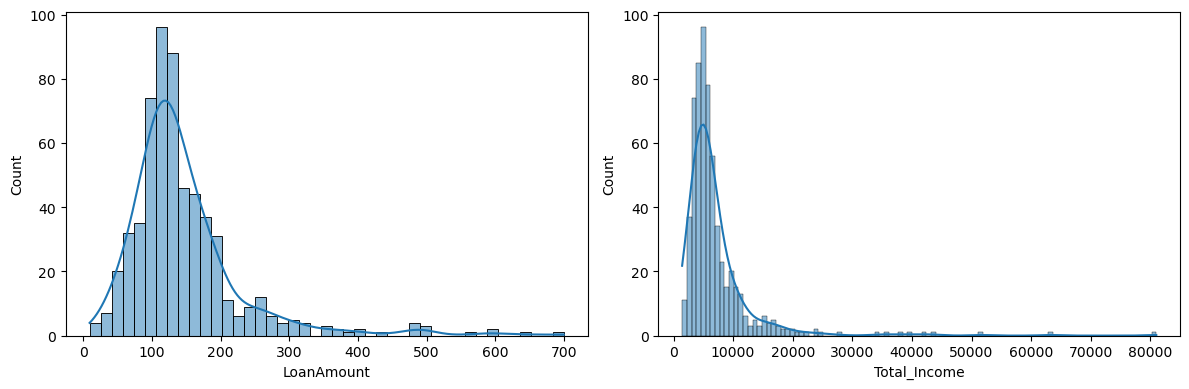

In [49]:
num_col_list=['LoanAmount', 'Total_Income']
fig, axes = plt.subplots(1, len(num_col_list), figsize=(12, 4))
for i, col in enumerate(num_col_list):
    sns.histplot(train[col], kde=True, ax=axes[i]) 
plt.tight_layout()
plt.show()

Since, distribution for ApplicantIncome, CoapplicantIncome, and LoanAmount is positively skewed, we need treat this

Log Transformation

In [50]:
cols=['LoanAmount', 'Total_Income']
for col in cols:
    train[col + '_log'] = np.sqrt(train[col])
    test[col + '_log'] = np.sqrt(test[col])

In [51]:
train.drop(columns=['LoanAmount', 'Total_Income'], inplace=True)
test.drop(columns=['LoanAmount', 'Total_Income'], inplace=True)
train = train.rename(columns={'LoanAmount_log': 'LoanAmount'})
test = test.rename(columns={'LoanAmount_log': 'LoanAmount'})
train = train.rename(columns={'Total_Income_log': 'Total_Income'})
test = test.rename(columns={'Total_Income_log': 'Total_Income'})

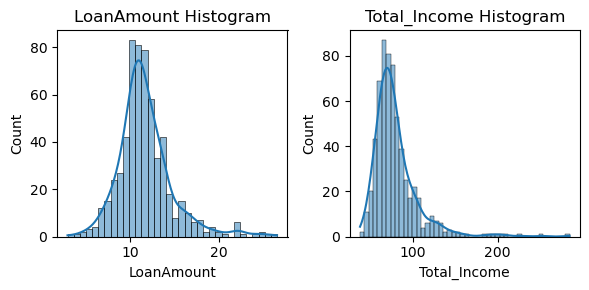

In [52]:
num_cols=['LoanAmount', 'Total_Income']
fig, axes = plt.subplots(1, 2, figsize=(6,3))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.histplot(train[col], kde=True, ax=axes[i])
    axes[i].set_title(f"{col} Histogram")
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

👉 As can be seen, the distribution after using log transformation are much better compared to original distribution.

In [53]:
corr_matrix=train.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,Loan_Amount_Term,Credit_History,Loan_Status,LoanAmount,Total_Income
Loan_Amount_Term,1.000000,0.001470,-0.021268,0.061910,-0.063411
Credit_History,0.001470,1.000000,0.561678,-0.014854,0.005904
Loan_Status,-0.021268,0.561678,1.000000,-0.041103,-0.015230
LoanAmount,0.061910,-0.014854,-0.041103,1.000000,0.674917
Total_Income,-0.063411,0.005904,-0.015230,0.674917,1.000000


## 5.2 Handling Missing Values

In [54]:
print(cat_cols)
print(num_dis_cols)
print(num_cols)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
['Credit_History', 'Loan_Amount_Term']
['LoanAmount', 'Total_Income']


**Categorical Columns Imputation**

In [55]:
for col in (cat_cols+num_dis_cols):
    train[col]=train[col].fillna(train[col].dropna().mode().values[0])
    test[col]=test[col].fillna(test[col].dropna().mode().values[0])
train.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
LoanAmount          22
Total_Income         0
dtype: int64

**Numerical Columns Imputation**

In [56]:
print(train.LoanAmount.mean(), train.LoanAmount.median())
print(train.Total_Income.mean(), train.Total_Income.median())

11.709993951871724 11.313708498984761
79.52029335072666 73.5968748552626


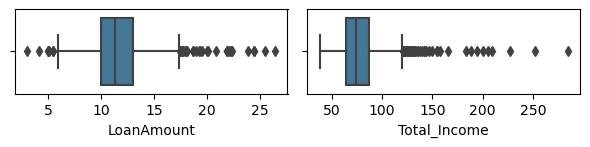

In [57]:
plt.figure(figsize=(6,4))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=col,  data=train, palette="mako")
plt.tight_layout()
plt.show()

In [58]:
train['LoanAmount']=train['LoanAmount'].fillna(train['LoanAmount'].dropna().median())
test['LoanAmount']=test['LoanAmount'].fillna(test['LoanAmount'].dropna().median())
train['Total_Income']=train['Total_Income'].fillna(train['Total_Income'].dropna().median())
test['Total_Income']=test['Total_Income'].fillna(test['Total_Income'].dropna().median())
total_null=train.isnull().sum().sort_values(ascending=False)
total_null

Gender              0
Married             0
Dependents          0
Education           0
Self_Employed       0
Loan_Amount_Term    0
Credit_History      0
Property_Area       0
Loan_Status         0
LoanAmount          0
Total_Income        0
dtype: int64

## 5.2 Outliers removal

In [59]:
train_df = pd.get_dummies(train)
test_df = pd.get_dummies(test)

In [60]:
from scipy import stats

z_scores = stats.zscore(train_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1) 
df1 = train_df[filtered_entries]

print(train_df.shape)
print(df1.shape)

(614, 20)
(538, 20)


In [61]:
df_train=pd.DataFrame(MinMaxScaler().fit_transform(df1), columns=df1.columns)
df_test=pd.DataFrame(MinMaxScaler().fit_transform(test_df), columns=test_df.columns)
df_train.head()

,Loan_Amount_Term,Credit_History,Loan_Status,LoanAmount,Total_Income,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0.6,1.0,1.0,0.485483,0.331004,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.6,1.0,0.0,0.485483,0.344467,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.6,1.0,1.0,0.299221,0.144407,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.6,1.0,1.0,0.464504,0.277823,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.6,1.0,1.0,0.518222,0.339437,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [62]:
df_train.Loan_Status.value_counts()

1.0    372
0.0    166
Name: Loan_Status, dtype: int64

# 5. Splitting the Dataset

In [63]:
X = df_train.drop(['Loan_Status'], axis=1)
y = df_train['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(430, 19) (108, 19)


In [64]:
y_test.value_counts()

1.0    72
0.0    36
Name: Loan_Status, dtype: int64

# 6. Feature Selection

In [65]:
selector = SelectPercentile(score_func=chi2, percentile=80)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
selected_features = X_train.columns[selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = selector.transform(X_test)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features)
X_train_selected_df.columns

Index(['Credit_History', 'LoanAmount', 'Gender_Female', 'Gender_Male',
       'Married_No', 'Married_Yes', 'Dependents_1', 'Dependents_2',
       'Education_Graduate', 'Education_Not Graduate', 'Self_Employed_No',
       'Self_Employed_Yes', 'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')

# 7. Model Building

In [66]:
Classifiers=[]

## 7.1 K-Nearest Neighbour (KNN)

In [67]:
'''classifier=KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],      
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}
grid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_selected, y_train)
best_params=grid_search.best_params_
model1=grid_search.best_estimator_
Classifiers.append(model1)
print(best_params, 'model1 = ', model1) '''

"classifier=KNeighborsClassifier()\nparam_grid = {\n    'n_neighbors': [3, 5, 7, 9, 11],      \n    'weights': ['uniform', 'distance'],  \n    'metric': ['euclidean', 'manhattan']  \n}\ngrid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')\ngrid_search.fit(X_train_selected, y_train)\nbest_params=grid_search.best_params_\nmodel1=grid_search.best_estimator_\nClassifiers.append(model1)\nprint(best_params, 'model1 = ', model1) "

In [68]:
model1 = KNeighborsClassifier(metric='euclidean', n_neighbors=9)

## 7.2 DecisionTree Classifier

In [69]:
''' classifier=DecisionTreeClassifier(random_state=0)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 0.5, 0.75],
    'max_leaf_nodes': [None, 10, 17, 20, 30],
}
grid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_selected, y_train)
best_params=grid_search.best_params_
model2=grid_search.best_estimator_
Classifiers.append(model2)
print(best_params, 'model2 = ', model2)'''

" classifier=DecisionTreeClassifier(random_state=0)\nparam_grid = {\n    'criterion': ['gini', 'entropy'],\n    'max_depth': [None, 5, 10, 20, 30],\n    'min_samples_split': [2, 5, 10, 20],\n    'min_samples_leaf': [1, 2, 5, 10],\n    'max_features': [None, 0.5, 0.75],\n    'max_leaf_nodes': [None, 10, 17, 20, 30],\n}\ngrid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')\ngrid_search.fit(X_train_selected, y_train)\nbest_params=grid_search.best_params_\nmodel2=grid_search.best_estimator_\nClassifiers.append(model2)\nprint(best_params, 'model2 = ', model2)"

In [70]:
model2 = DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=0.75, max_leaf_nodes=17, random_state=0)

## 7.3 RandomForest Classifier

In [71]:
'''classifier=RandomForestClassifier()
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_samples': [None, 0.5, 0.75, 1.0],
    'max_leaf_nodes' : [18, 20]
}
grid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_selected, y_train)
best_params=grid_search.best_params_
model3=grid_search.best_estimator_
Classifiers.append(model3)
print(best_params, 'model3 = ', model3)'''

"classifier=RandomForestClassifier()\nparam_grid = {\n    'n_estimators': [500, 1000],\n    'max_depth': [None, 5, 10, 20],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'criterion': ['gini', 'entropy'],\n    'max_samples': [None, 0.5, 0.75, 1.0],\n    'max_leaf_nodes' : [18, 20]\n}\ngrid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')\ngrid_search.fit(X_train_selected, y_train)\nbest_params=grid_search.best_params_\nmodel3=grid_search.best_estimator_\nClassifiers.append(model3)\nprint(best_params, 'model3 = ', model3)"

In [72]:
model3 = RandomForestClassifier(max_leaf_nodes=18, min_samples_split=10, n_estimators=500)

## 7.4 SVC

In [73]:
'''classifier=SVC(max_iter=500)
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'degree': [2, 3, 4],
    'probability': [True, False],
}
grid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_selected, y_train)
best_params=grid_search.best_params_
model4 =grid_search.best_estimator_
Classifiers.append(model4)
print(best_params, 'model4 = ', model4)'''

"classifier=SVC(max_iter=500)\nparam_grid = {\n    'C': [0.01, 0.1, 1.0, 10.0, 100.0],\n    'kernel': ['linear', 'rbf'],\n    'gamma': [0.001, 0.01, 0.1, 1, 10],\n    'degree': [2, 3, 4],\n    'probability': [True, False],\n}\ngrid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')\ngrid_search.fit(X_train_selected, y_train)\nbest_params=grid_search.best_params_\nmodel4 =grid_search.best_estimator_\nClassifiers.append(model4)\nprint(best_params, 'model4 = ', model4)"

In [74]:
model4 = SVC(C=0.1, degree=2, gamma=0.001, kernel='linear', max_iter=500, probability=True)

## 7.5 Logistic Regression

In [75]:
'''classifier=LogisticRegression(random_state=42)
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['saga', 'liblinear'],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 300, 400, 500],
}

grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='f1')
grid_search.fit(X_train_selected, y_train)
best_params=grid_search.best_params_
model5=grid_search.best_estimator_
Classifiers.append(model5)
print(best_params, 'model5 = ', model5)'''

"classifier=LogisticRegression(random_state=42)\nparam_grid = {\n    'C': [0.01, 0.1, 1.0, 10.0, 100.0],\n    'solver': ['saga', 'liblinear'],\n    'penalty': ['l1', 'l2'],\n    'max_iter': [100, 200, 300, 400, 500],\n}\n\ngrid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='f1')\ngrid_search.fit(X_train_selected, y_train)\nbest_params=grid_search.best_params_\nmodel5=grid_search.best_estimator_\nClassifiers.append(model5)\nprint(best_params, 'model5 = ', model5)"

In [76]:
model5 = LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')

## 7.6 XGBClassifier

In [77]:
'''classifier=XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    }
grid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_selected, y_train)
best_params=grid_search.best_params_
model6=grid_search.best_estimator_
Classifiers.append(model6)
print(best_params, 'model6= ', model6)'''

"classifier=XGBClassifier(use_label_encoder=False, eval_metric='logloss')\nparam_grid = {\n    'n_estimators': [50, 100, 200, 500],\n    'max_depth': [3, 5, 7, 10],\n    'learning_rate': [0.01, 0.1, 0.2, 0.3],\n    'subsample': [0.6, 0.8, 1.0],\n    'colsample_bytree': [0.6, 0.8, 1.0],\n    }\ngrid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')\ngrid_search.fit(X_train_selected, y_train)\nbest_params=grid_search.best_params_\nmodel6=grid_search.best_estimator_\nClassifiers.append(model6)\nprint(best_params, 'model6= ', model6)"

In [78]:
model6 = XGBClassifier(colsample_bytree = 0.6, learning_rate = 0.01, max_depth = 3, n_estimators = 200, subsample = 0.6)

In [79]:
Classifiers=[model1, model2, model3, model4, model5, model6]

# 8. Model Comparison

In [80]:
accuracies = []
for model in Classifiers:
    model.fit(X_train_selected_df, y_train)
    accuracy = model.score(X_train_selected_df, y_train)
    accuracies.append(accuracy)
compare = pd.DataFrame({
    'Model': Classifiers,
    'Train_Accuracy': accuracies
})
compare = compare.sort_values(by='Train_Accuracy', ascending=False)
compare

,Model,Train_Accuracy
1,"DecisionTreeClassifier(criterion='entropy', ma...",0.827907
2,"(DecisionTreeClassifier(max_features='sqrt', m...",0.811628
3,"SVC(C=0.1, degree=2, gamma=0.001, kernel='line...",0.811628
4,"LogisticRegression(C=0.1, penalty='l1', random...",0.811628
5,"XGBClassifier(base_score=None, booster=None, c...",0.811628
0,"KNeighborsClassifier(metric='euclidean', n_nei...",0.772093


In [81]:
predictions=[]
for model in Classifiers:
    y_test_pred=model.predict(X_test_selected_df)
    predictions.append(y_test_pred)
test_accuracies=[]
for pred in predictions:
    accuracy = accuracy_score(y_test, pred)
    test_accuracies.append(accuracy)

compare = pd.DataFrame({
    'Model': Classifiers,
    'Test_ Accuracy': test_accuracies
})
compare = compare.sort_values(by='Test_ Accuracy', ascending=False)
compare

,Model,Test_ Accuracy
1,"DecisionTreeClassifier(criterion='entropy', ma...",0.842593
2,"(DecisionTreeClassifier(max_features='sqrt', m...",0.842593
3,"SVC(C=0.1, degree=2, gamma=0.001, kernel='line...",0.842593
4,"LogisticRegression(C=0.1, penalty='l1', random...",0.842593
5,"XGBClassifier(base_score=None, booster=None, c...",0.842593
0,"KNeighborsClassifier(metric='euclidean', n_nei...",0.703704


In [82]:
for clf in Classifiers:
    clf.fit(X_train_selected, y_train)
    y_pred=clf.predict(X_train_selected)
    y_test_pred=clf.predict(X_test_selected)
    print(f"Model: {clf.__class__.__name__}")
    
    train_accuracy = 100*accuracy_score(y_train, y_pred)
    train_precision = precision_score(y_train, y_pred)
    train_recall = recall_score(y_train, y_pred)
    train_f1 = 100*f1_score(y_train, y_pred)
    
    test_accuracy = 100*accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = 100*f1_score(y_test, y_test_pred)
    
    print(f"Train Accuracy: {train_accuracy:.2f},  F1 Score: {train_f1:.2f}, Precision:{train_precision:.2f}, Recall:{train_recall:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}, F1 Score: {test_f1:.2f}, Precision:{test_precision:.2f}, Recall:{test_recall:.2f}")
    print('---------------------------')
    print()


Model: KNeighborsClassifier
Train Accuracy: 77.21,  F1 Score: 85.80, Precision:0.76, Recall:0.99
Test Accuracy: 70.37, F1 Score: 81.40, Precision:0.70, Recall:0.97
---------------------------

Model: DecisionTreeClassifier
Train Accuracy: 82.79,  F1 Score: 88.86, Precision:0.81, Recall:0.98
Test Accuracy: 84.26, F1 Score: 89.17, Precision:0.82, Recall:0.97
---------------------------

Model: RandomForestClassifier
Train Accuracy: 81.16,  F1 Score: 87.96, Precision:0.79, Recall:0.99
Test Accuracy: 84.26, F1 Score: 89.31, Precision:0.82, Recall:0.99
---------------------------

Model: SVC
Train Accuracy: 81.16,  F1 Score: 87.96, Precision:0.79, Recall:0.99
Test Accuracy: 84.26, F1 Score: 89.31, Precision:0.82, Recall:0.99
---------------------------

Model: LogisticRegression
Train Accuracy: 81.16,  F1 Score: 87.96, Precision:0.79, Recall:0.99
Test Accuracy: 84.26, F1 Score: 89.31, Precision:0.82, Recall:0.99
---------------------------

Model: XGBClassifier
Train Accuracy: 81.16,  F1 Sc

In [83]:
for clf in Classifiers:
    clf.fit(X_train_selected, y_train)
    y_test_pred=clf.predict(X_test_selected)
    print(f"Model: Classification Report of {clf.__class__.__name__}")
    print(classification_report(y_test, y_test_pred, zero_division='warn'))
    print()

Model: Classification Report of KNeighborsClassifier
              precision    recall  f1-score   support

         0.0       0.75      0.17      0.27        36
         1.0       0.70      0.97      0.81        72

    accuracy                           0.70       108
   macro avg       0.72      0.57      0.54       108
weighted avg       0.72      0.70      0.63       108


Model: Classification Report of DecisionTreeClassifier
              precision    recall  f1-score   support

         0.0       0.91      0.58      0.71        36
         1.0       0.82      0.97      0.89        72

    accuracy                           0.84       108
   macro avg       0.87      0.78      0.80       108
weighted avg       0.85      0.84      0.83       108


Model: Classification Report of RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.95      0.56      0.70        36
         1.0       0.82      0.99      0.89        72

    accuracy     

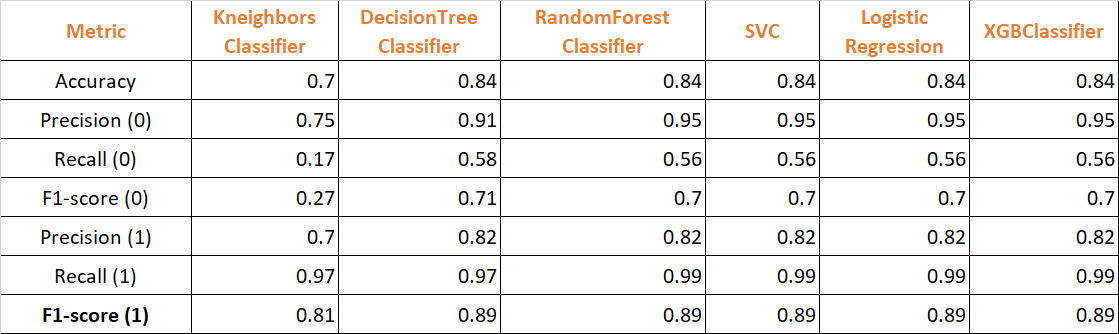!

🔝Top Three Classifiers:

**1. DecisionTreeClassifier: Accuracy: 0.84**
Balanced Performance: Provides a good balance between precision and recall for both classes.
Strengths: High precision for class 0 (0.91) and high recall for class 1 (0.97).

**2. RandomForestClassifier: Accuracy: 0.84**
High Precision: Excellent precision for class 0 (0.95), indicating fewer false positives.
Strengths: High rec all for class 1 (0.99), ensuring most positive cases are correctly identified.

**3. XGBClassifier:Accuracy: 0.84**
Consistent Performance: Matches the performance of RandomForest and SVC, with strong metrics across all categories.
Strengths: Reliable precision and recall for both classes, similar to RandomForestClassifier.


In [84]:
import sys
for clf in Classifiers:
    clf.fit(X_train_selected, y_train)
    y_test_pred=clf.predict(X_test_selected)
    sys.stdout.flush()      
    class_labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)
    '''disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot()
    plt.title(f"Confusion Matrix of {clf.__class__.__name__}")
    plt.show()  '''

[[ 6 30]
 [ 2 70]]
[[21 15]
 [ 2 70]]
[[20 16]
 [ 1 71]]
[[20 16]
 [ 1 71]]
[[20 16]
 [ 1 71]]
[[20 16]
 [ 1 71]]


Model: KNeighborsClassifier


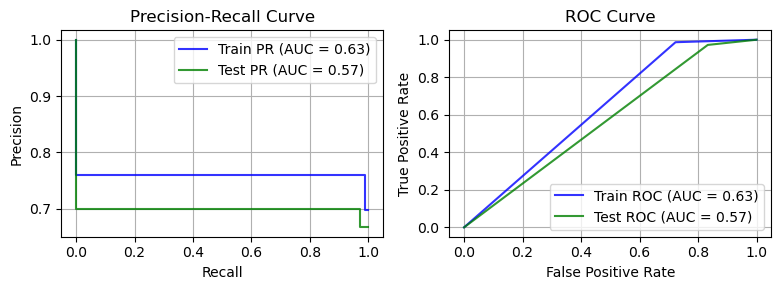



Model: DecisionTreeClassifier


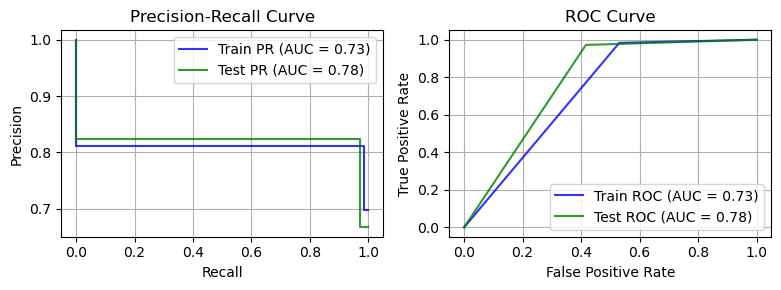



Model: RandomForestClassifier


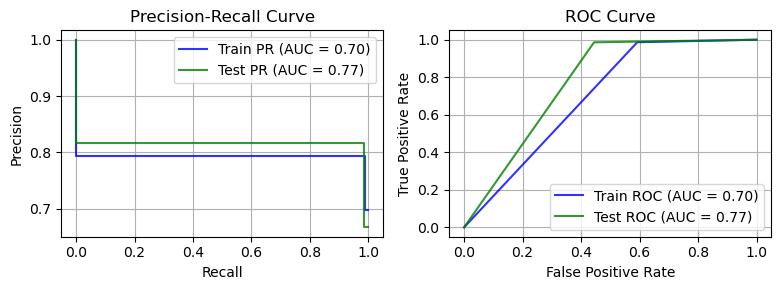



Model: SVC


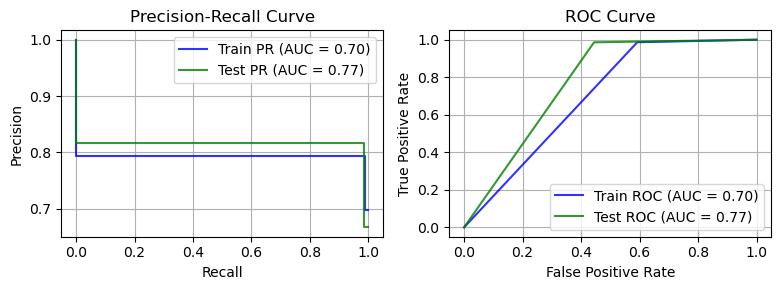



Model: LogisticRegression


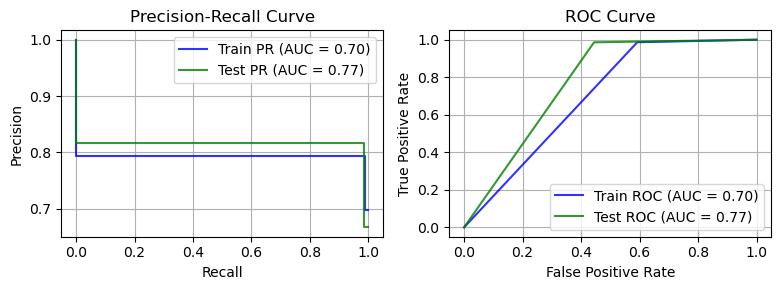



Model: XGBClassifier


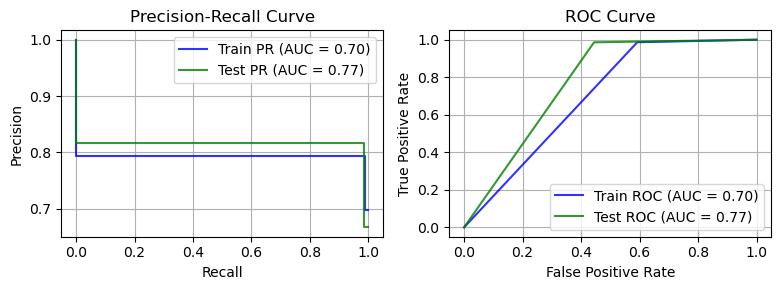

In [85]:
for clf in Classifiers:
    clf.fit(X_train_selected, y_train)
    y_pred=clf.predict(X_train_selected)
    y_test_pred=clf.predict(X_test_selected)
    print(f"Model: {clf.__class__.__name__}")    
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred)
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.figure(figsize=(8,3))
    plt.subplot(1, 2, 1) 
   
    plt.step(recall_train, precision_train, color='b', alpha=0.8, where='post', label='Train PR (AUC = %0.2f)' % roc_auc_train)
    plt.step(recall_test, precision_test, color='g', alpha=0.8, where='post', label='Test PR (AUC = %0.2f)' % roc_auc_test)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.subplot(1,2,2)
    plt.plot(fpr_train, tpr_train, color='b', alpha=0.8, label='Train ROC (AUC = %0.2f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='g', alpha=0.8, label='Test ROC (AUC = %0.2f)' % roc_auc_test)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()
    print()
    print()

# 9. Fine-Tuning (Handling Imbalance Dataset)

In [86]:
oversample=RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X,y)
df_new=pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled , name='Loan_Status')], axis=1)
X_new = df_new.drop(['Loan_Status'], axis=1)
y_new = df_new['Loan_Status']
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)
print(X_train_new.shape, X_test_new.shape)

(595, 19) (149, 19)


In [87]:
#selector = SelectKBest(score_func=chi2, k=15)
selector = SelectPercentile(score_func=chi2, percentile=80)
X_train = selector.fit_transform(X_train_new, y_train)
X_test = selector.transform(X_test_new)
print(X_train.shape)
print(y_train.shape)

(595, 15)
(595,)


## 9.1 K-Nearest Neighbour (KNN) Classifier

In [88]:
classifier=KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],      
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}
grid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_params=grid_search.best_params_
model1=grid_search.best_estimator_
print(best_params)
print('model1= ', model1)

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
model1=  KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance')


## 9.2 DecisionTree Classifier

In [89]:
classifier=DecisionTreeClassifier(random_state=0)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [0.5, 0.75],
    'max_leaf_nodes': [None, 10, 20],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1]
}
grid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_params=grid_search.best_params_
model2=grid_search.best_estimator_
print(best_params, 'model2= ', model2)

{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.5, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2} model2=  DecisionTreeClassifier(criterion='entropy', max_features=0.5, random_state=0)


## 9.3 RandomForest Classifier

In [90]:
classifier=RandomForestClassifier()
param_grid = {
    'n_estimators': [100,200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_samples': [None, 0.75, 1.0]
}
grid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_params=grid_search.best_params_
model3=grid_search.best_estimator_
print(best_params, 'model3= ', model3)

{'criterion': 'entropy', 'max_depth': 10, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} model3=  RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200)


## 9.4 XGB Classifier

In [91]:
classifier=XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    }
grid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_params=grid_search.best_params_
model4=grid_search.best_estimator_
print(best_params, 'model4: ', model4)

{'colsample_bytree': 0.6, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8} model4:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)


## 9.5 SVC

In [92]:
classifier=SVC()
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'degree': [2, 3, 4],
    'probability': [True, False],
}
grid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_params=grid_search.best_params_
model5=grid_search.best_estimator_
print(best_params, 'model5: ', model5)

{'C': 1.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True} model5:  SVC(degree=2, gamma=0.01, probability=True)


## 9.6 Logistic Regresssion

In [93]:
classifier=LogisticRegression(random_state=1)
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['lbfgs', 'saga', 'liblinear'],
    'penalty': ['l1', 'l2'],
    'max_iter': [500, 1000],
}
grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)
best_params=grid_search.best_params_
model6=grid_search.best_estimator_
print(best_params, 'model6: ', model6)

C:\Users\91733\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\91733\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\91733\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\91733\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'C': 0.1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'} model6:  LogisticRegression(C=0.1, max_iter=500, penalty='l1', random_state=1,
                   solver='liblinear')


C:\Users\91733\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\91733\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\91733\anaconda3\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\91733\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual

In [94]:
classifiers=[model1, model2, model3, model4, model5, model6]

In [95]:
for clf in Classifiers:
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_train)
    y_test_pred=clf.predict(X_test)
    print(f"Model: {clf.__class__.__name__}")
    
    train_accuracy = 100*accuracy_score(y_train, y_pred)
    train_precision = precision_score(y_train, y_pred)
    train_recall = recall_score(y_train, y_pred)
    train_f1 = 100*f1_score(y_train, y_pred)
    
    test_accuracy = 100*accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = 100*f1_score(y_test, y_test_pred)
    
    print(f"Train Accuracy: {train_accuracy:.2f},  F1 Score: {train_f1:.2f}, Precision:{train_precision:.2f}, Recall:{train_recall:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}, F1 Score: {test_f1:.2f}, Precision:{test_precision:.2f}, Recall:{test_recall:.2f}")
    print('---------------------------')
    print()


Model: KNeighborsClassifier
Train Accuracy: 78.15,  F1 Score: 77.97, Precision:0.77, Recall:0.79
Test Accuracy: 67.11, F1 Score: 69.94, Precision:0.70, Recall:0.70
---------------------------

Model: DecisionTreeClassifier
Train Accuracy: 74.96,  F1 Score: 78.06, Precision:0.68, Recall:0.91
Test Accuracy: 75.84, F1 Score: 80.43, Precision:0.73, Recall:0.90
---------------------------

Model: RandomForestClassifier
Train Accuracy: 84.20,  F1 Score: 84.18, Precision:0.82, Recall:0.86
Test Accuracy: 77.85, F1 Score: 80.00, Precision:0.80, Recall:0.80
---------------------------

Model: SVC
Train Accuracy: 69.41,  F1 Score: 75.80, Precision:0.62, Recall:0.98
Test Accuracy: 77.18, F1 Score: 82.83, Precision:0.71, Recall:1.00
---------------------------

Model: LogisticRegression
Train Accuracy: 69.41,  F1 Score: 75.80, Precision:0.62, Recall:0.98
Test Accuracy: 77.18, F1 Score: 82.83, Precision:0.71, Recall:1.00
---------------------------

Model: XGBClassifier
Train Accuracy: 76.30,  F1 Sc

In [96]:
for clf in Classifiers:
    clf.fit(X_train, y_train)
    y_test_pred=clf.predict(X_test)
    print(f"Model: Classification Report of {clf.__class__.__name__}")
    print(classification_report(y_test, y_test_pred))
    print()

Model: Classification Report of KNeighborsClassifier
              precision    recall  f1-score   support

         0.0       0.63      0.64      0.64        67
         1.0       0.70      0.70      0.70        82

    accuracy                           0.67       149
   macro avg       0.67      0.67      0.67       149
weighted avg       0.67      0.67      0.67       149


Model: Classification Report of DecisionTreeClassifier
              precision    recall  f1-score   support

         0.0       0.83      0.58      0.68        67
         1.0       0.73      0.90      0.80        82

    accuracy                           0.76       149
   macro avg       0.78      0.74      0.74       149
weighted avg       0.77      0.76      0.75       149


Model: Classification Report of RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76        67
         1.0       0.80      0.82      0.81        82

    accuracy     

Model: KNeighborsClassifier


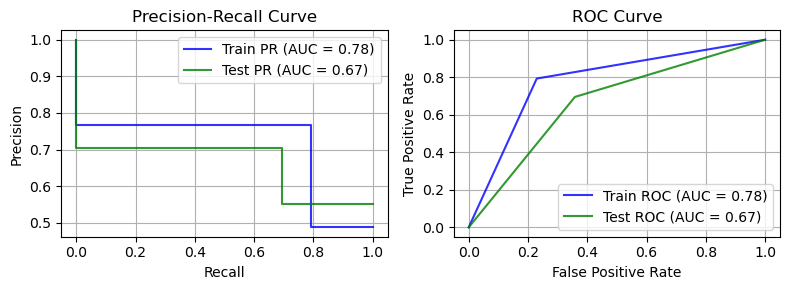



Model: DecisionTreeClassifier


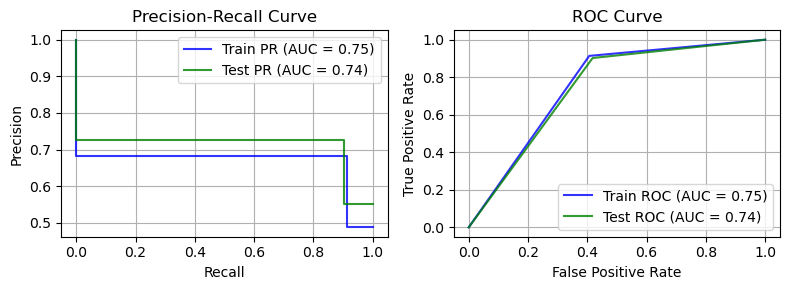



Model: RandomForestClassifier


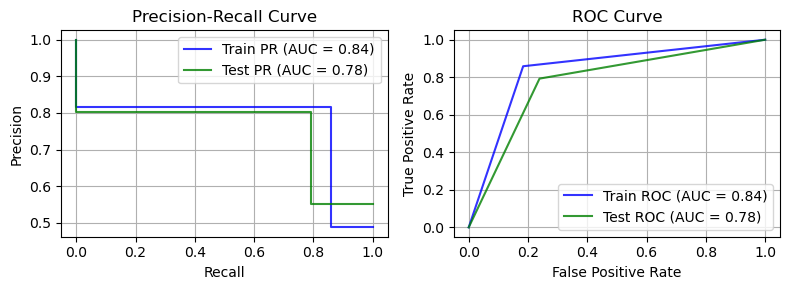



Model: SVC


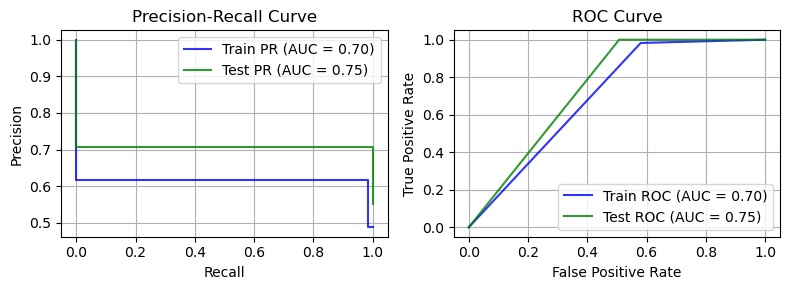



Model: LogisticRegression


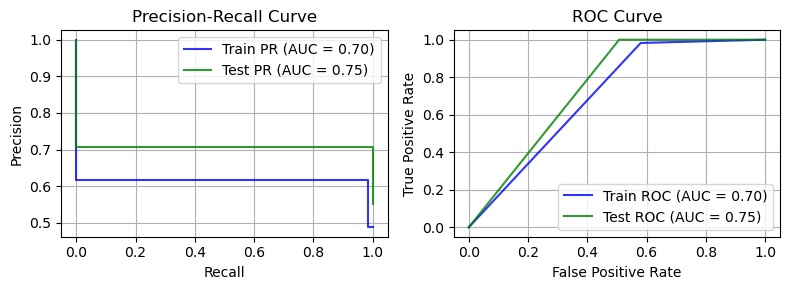



Model: XGBClassifier


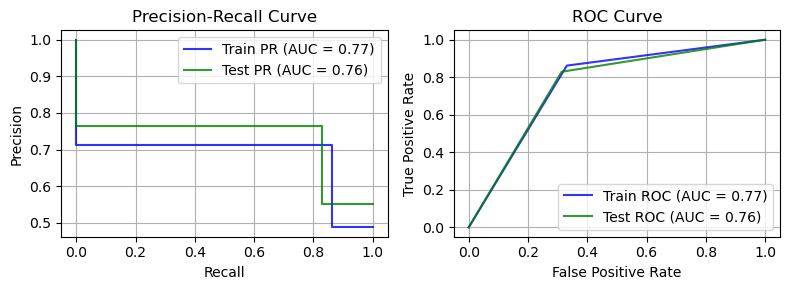

In [97]:
for clf in Classifiers:
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_train)
    y_test_pred=clf.predict(X_test)
    print(f"Model: {clf.__class__.__name__}")    
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred)
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.figure(figsize=(8,3))
    plt.subplot(1, 2, 1) 
   
    plt.step(recall_train, precision_train, color='b', alpha=0.8, where='post', label='Train PR (AUC = %0.2f)' % roc_auc_train)
    plt.step(recall_test, precision_test, color='g', alpha=0.8, where='post', label='Test PR (AUC = %0.2f)' % roc_auc_test)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.subplot(1,2,2)
    plt.plot(fpr_train, tpr_train, color='b', alpha=0.8, label='Train ROC (AUC = %0.2f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='g', alpha=0.8, label='Test ROC (AUC = %0.2f)' % roc_auc_test)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()
    print()
    print()

Model: KNeighborsClassifier


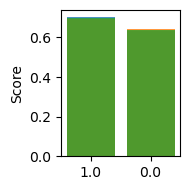

Model: DecisionTreeClassifier


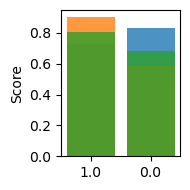

Model: RandomForestClassifier


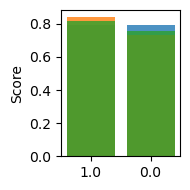

Model: SVC


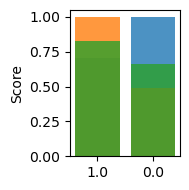

Model: LogisticRegression


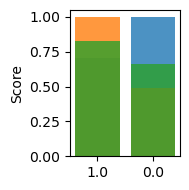

Model: XGBClassifier


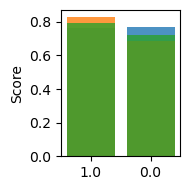

In [98]:
for clf in Classifiers:
    print(f"Model: {clf.__class__.__name__}")
    clf.fit(X_train, y_train)
    y_test_pred=clf.predict(X_test)
    report = classification_report(y_test, y_test_pred, output_dict=True, zero_division='warn')
    class_names = ['1.0', '0.0'] 
    
    precision = [report[class_name]['precision'] for class_name in class_names]
    recall = [report[class_name]['recall'] for class_name in class_names]
    f1_score = [report[class_name]['f1-score'] for class_name in class_names]
    
    plt.figure(figsize=(2,2))
    plt.bar(class_names, precision, label='Precision', alpha=0.8)
    plt.bar(class_names, recall, label='Recall', alpha=0.8)
    plt.bar(class_names, f1_score, label='F1-score', alpha=0.8)
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()

# 10. Deployment

In [99]:
test_data=pd.DataFrame(selector.transform(df_test))
y_test_pred=model1.predict(test_data)
test['Loan_Status'] = y_test_pred
test1=pd.DataFrame()
test1['Loan_ID']=test2['Loan_ID']
test1['Loan_Status'] =test['Loan_Status'].map({1: 'Y', 0:'N'})
test1.to_csv('LoanStatusPredictiontrial1.csv', index=False)
print(test1.head())

    Loan_ID Loan_Status
0  LP001015           Y
1  LP001022           Y
2  LP001031           N
3  LP001035           Y
4  LP001051           N
